In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../../Notebooks')
from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load pre-trained KG model:

In [6]:
PATH_TRANS_E = '../Notebooks/dataset/transE_fb15k_256dim.pkl'

In [7]:
BASE_PATH_TRUTH = '../Notebooks/dataset/Release'

In [8]:
# transe_fb15k-237.pkl: pre-trained model of fb15k with 1024 dim.
with open(PATH_TRANS_E, "rb") as fin:
    model = pickle.load(fin)
    
entity2id = model.graph.entity2id
relation2id = model.graph.relation2id

entity_embeddings = model.solver.entity_embeddings
relation_embeddings = model.solver.relation_embeddings

entity_embeddings.shape

(14951, 256)

## Get ground-truth from FB dataset:

In [9]:
fb_train=pd.read_csv(BASE_PATH_TRUTH + '/train.txt', sep='\t', header=None, index_col=0)
fb_valid=pd.read_csv(BASE_PATH_TRUTH + '/valid.txt', sep='\t', header=None, index_col=0)
fb_test=pd.read_csv(BASE_PATH_TRUTH + '/test.txt', sep='\t', header=None, index_col=0)

fb_df=pd.concat([fb_train, fb_valid, fb_test])
fb_df['type']= fb_df[1].apply(lambda x: x.split('/')[1])

In [10]:
fb_df['type']

0
/m/027rn          location
/m/017dcd               tv
/m/07s9rl0    media_common
/m/01sl1q            award
/m/0cnk2q           soccer
                  ...     
/m/0l5yl            people
/m/01z5tr           people
/m/0p5mw             music
/m/0727h          military
/m/050r1z             film
Name: type, Length: 310116, dtype: object

### Get types for FB15k entities:

In [11]:
ground_truth={}
for entity_id in entity2id.keys():
    if entity_id in fb_df.index:
        if isinstance(fb_df.loc[entity_id, 'type'], pd.core.series.Series): 
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type'][0]
        else:
            ground_truth[entity_id]=fb_df.loc[entity_id, 'type']
    else:
        ground_truth[entity_id]='unknown' # for missed types

In [12]:
# count frequent types in ground_truth
from collections import Counter
Counter(ground_truth.values()).most_common()

[('award', 2552),
 ('people', 2184),
 ('film', 2158),
 ('location', 1472),
 ('unknown', 1060),
 ('music', 767),
 ('soccer', 693),
 ('common', 618),
 ('education', 617),
 ('base', 611),
 ('sports', 434),
 ('tv', 325),
 ('organization', 317),
 ('user', 161),
 ('business', 146),
 ('olympics', 137),
 ('government', 135),
 ('influence', 118),
 ('military', 67),
 ('media_common', 64),
 ('medicine', 55),
 ('language', 51),
 ('time', 43),
 ('travel', 42),
 ('dataworld', 28),
 ('ice_hockey', 28),
 ('food', 22),
 ('celebrities', 20),
 ('american_football', 18),
 ('baseball', 5),
 ('broadcast', 3)]

In [13]:
#filter top commen types
entity_embedding_filter=[]
y_true_filter=[]

top_types=['people', 'film', 'location', 'music', 'soccer', 'education']

for k, value in ground_truth.items():
    if value in top_types:        
        entity_embedding_filter.append(entity_embeddings[entity2id[k]])
        y_true_filter.append(value)

In [14]:
X_all = np.asarray(entity_embedding_filter)
X_all.shape

(7891, 256)

In [15]:
encoder = LabelEncoder()
y_all = encoder.fit_transform(y_true_filter)
labels = encoder.classes_.tolist()

## t-SNE Freebase visualization

In [16]:
projection_full = TSNE(random_state=42).fit_transform(X_all)

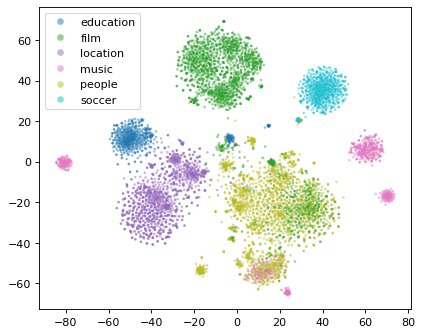

In [17]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_all, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

#plt.savefig('./fb15k-transE-full.pdf', dpi=100)

## Unsupervisied:

## HDBSCAN:

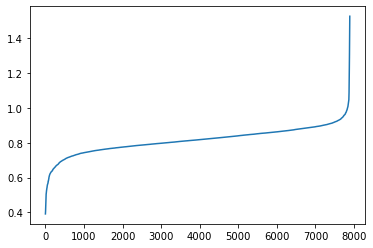

In [35]:
# final optimal value for cluster epsilon
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_all)
distances, indices = nbrs.kneighbors(X_all)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]
plt.plot(distances)

In [18]:
X_all_double=X_all.astype(np.double)

In [21]:
%%time
hdbscan_clusterer=hdbscan.HDBSCAN(algorithm='best', alpha=0.1, metric='precomputed', cluster_selection_method='leaf',
                                      min_samples=10, min_cluster_size=700, core_dist_n_jobs=-1,allow_single_cluster=True,
                                      cluster_selection_epsilon=0.9)

distance_matrix = pairwise_distances(X_all_double, metric='cosine')
hdbscan_clusterer.fit(distance_matrix)

y_hdbscan=hdbscan_clusterer.labels_

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_hdbscan': y_hdbscan, 'y_all': y_all})
pred_hdbscan = df_tmp.groupby('pred_hdbscan').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 4.46 s, sys: 2.69 s, total: 7.15 s
Wall time: 5.07 s


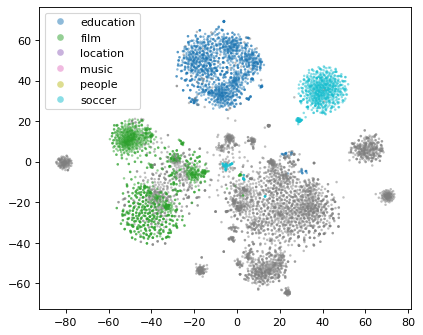

In [39]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_hdbscan, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-hdbscan.pdf', dpi=100)

In [22]:
accuracy = accuracy_score(y_all, pred_hdbscan)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_hdbscan, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_hdbscan, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_hdbscan, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_hdbscan))

Accuracy: 0.678748
Precision: 0.617051
Recall: 0.678748
F1 score: 0.624435
Purity:  0.6787479406919276


## Centroid-based Clustering (K-means):

In [23]:
%%time
kmeans = KMeans(n_clusters=len(top_types)).fit(X_all)
pred_kmeans = kmeans.predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_kmeans': pred_kmeans, 'y_all': y_all})
pred_kmeans = df_tmp.groupby('pred_kmeans').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 3.91 s, sys: 251 ms, total: 4.16 s
Wall time: 907 ms


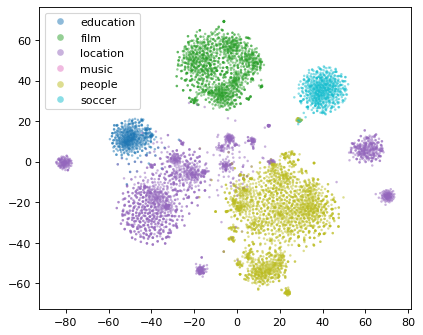

In [25]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_kmeans, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-Kmeans.pdf', dpi=100)


In [26]:
accuracy = accuracy_score(y_all, pred_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_kmeans, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_kmeans, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_kmeans))

Accuracy: 0.784058
Precision: 0.753399
Recall: 0.784058
F1 score: 0.751127
Purity:  0.7840577873526803


## Agglomerative Clustering:

In [24]:
%%time
aggClustering = AgglomerativeClustering(n_clusters=len(top_types))
y_aggClustering=aggClustering.fit_predict(X_all)

# majority voting per cluster
df_tmp = pd.DataFrame({'pred_agglom': y_aggClustering, 'y_all': y_all})
pred_agglom = df_tmp.groupby('pred_agglom').transform(lambda x: x.mode().iloc[0]).to_numpy().reshape(-1)

CPU times: user 6.81 s, sys: 172 ms, total: 6.98 s
Wall time: 6.98 s


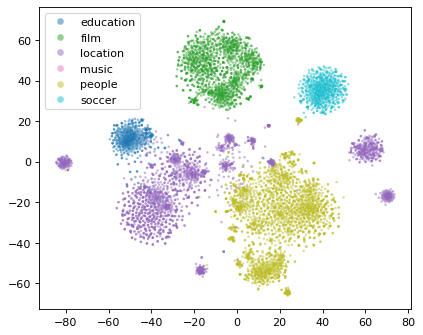

In [32]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=pred_agglom, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-agglom.pdf', dpi=100)


In [33]:
accuracy = accuracy_score(y_all, pred_agglom)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, pred_agglom, zero_division=0, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, pred_agglom, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, pred_agglom, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=pred_agglom))

Accuracy: 0.779242
Precision: 0.749701
Recall: 0.779242
F1 score: 0.746989
Purity:  0.7792421746293245


# Supervised Baselines:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

In [49]:
projection_train = TSNE(random_state=42).fit_transform(X_train)
projection_test = TSNE(random_state=42).fit_transform(X_test)

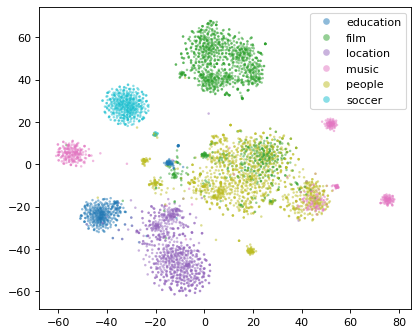

In [50]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_train[:, 0], projection_train[:, 1], s=5,  cmap='tab10', c=y_train, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-transE-train.pdf', dpi=100)

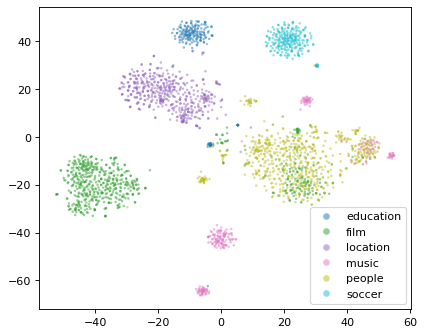

In [51]:
plt.figure(figsize=(6, 5), dpi=80)
scatter = plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_test, linewidth=0, alpha=0.5) 

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)

plt.savefig('./fb15k-transE-test.pdf', dpi=100)

## Logistic Regression:

In [26]:
%%time

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

CPU times: user 670 ms, sys: 8.11 ms, total: 678 ms
Wall time: 667 ms


In [47]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.900576
Precision: 0.908075
Recall: 0.900576
F1 score: 0.900413
Purity Score:  0.9005758157389635


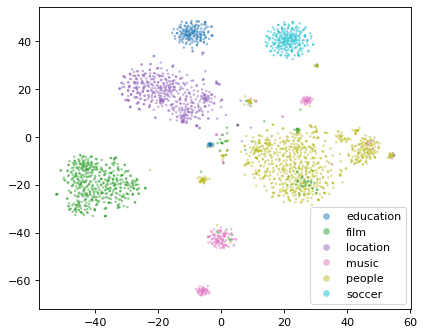

In [52]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_lr, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-logistic.pdf', dpi=100)


## KNN:

In [29]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

CPU times: user 6.69 s, sys: 4.09 ms, total: 6.69 s
Wall time: 6.69 s


In [53]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.874088
Precision: 0.874334
Recall: 0.874088
F1 score: 0.873252
Purity Score:  0.874088291746641


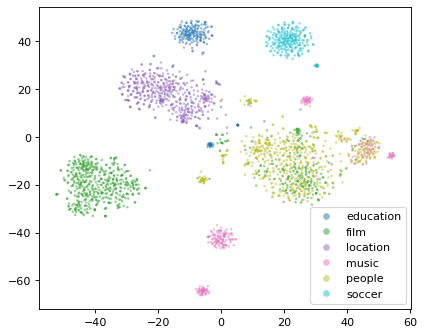

In [54]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_knn, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-knn.pdf', dpi=100)


## RandomForest:

In [30]:
%%time
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

CPU times: user 7.8 s, sys: 120 µs, total: 7.8 s
Wall time: 7.99 s


In [55]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.901344
Precision: 0.915580
Recall: 0.901344
F1 score: 0.901131
Purity Score:  0.9013435700575816


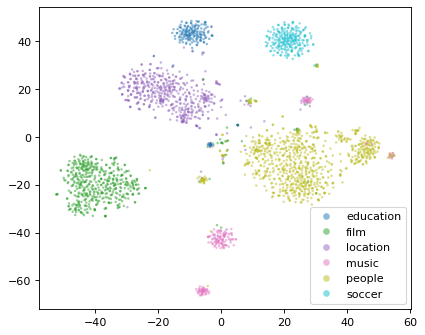

In [56]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_test[:, 0], projection_test[:, 1], s=5,  cmap='tab10', c=y_rf, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-RandomForest.pdf', dpi=100)

# Random Clustering:

In [95]:
y_random=np.random.choice([0, 1,2,3,4,5], size=y_all.shape[0])

In [96]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random))

Accuracy: 0.167913
Precision: 0.215190
Recall: 0.167913
F1 score: 0.180376
Purity:  0.28690913699150933


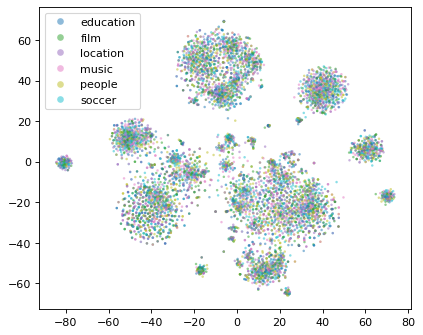

In [97]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_random, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-random.pdf', dpi=100)


## Random Clustering based on Type Distribution:

In [98]:
weights=[]
y_counts=Counter(y_all)

for i in range(len(top_types)):
    weights.append(y_counts[i]/y_all.shape[0])
    
weights    

[0.07819034342922317,
 0.27347611202635913,
 0.1865416297047269,
 0.09719934102141681,
 0.27677100494233936,
 0.0878215688759346]

In [99]:

y_random_bala=np.random.choice([0,1,2,3,4,5], size=y_all.shape[0], p=weights)

In [100]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_all, y_random_bala)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_all, y_random_bala, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_all, y_random_bala, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_all, y_random_bala, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_all, y_pred=y_random_bala))

Accuracy: 0.207071
Precision: 0.206207
Recall: 0.207071
F1 score: 0.206625
Purity:  0.27930553795463187


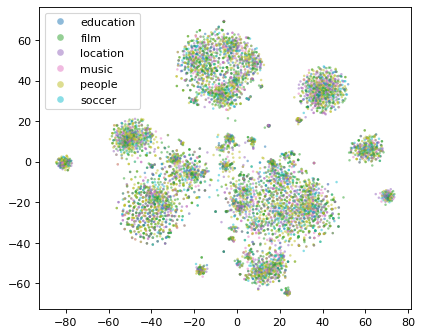

In [101]:
plt.figure(figsize=(6, 5), dpi=80)
plt.scatter(projection_full[:, 0], projection_full[:, 1], s=5,  cmap='tab10', c=y_random_bala, linewidth=0, alpha=0.5)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.savefig('./fb15k-transE-randomBala.pdf', dpi=100)
